In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

from tqdm import tqdm

print(tf.__version__)

2.3.0


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving methods.py to methods.py


In [ ]:
from methods import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
simulations_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/RMS_FULL_26_Processed'
bin_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin'

In [ ]:
files = glob(simulations_path +"/26*.csv")

In [ ]:
#getting column names and file shapes
columns = pd.read_csv(next(iter(files)), index_col=0)
columns = columns.iloc[:, 2:]
n_rows = columns.shape[0]
n_cols = columns.shape[1]
columns = columns.columns
print(next(iter(files)))
print(columns)
print("Number of rows: " + str(n_rows))
print("Number of columns: " + str(n_cols))

/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/RMS_FULL_26_Processed/26%_wind_Line 27-28_clearing-0.3_load-0.8_inertia-2.33_spinreserve-2696.0_.csv
Index(['volt_mag Gen 10', 'volt_mag Gen 12', 'volt_mag Gen 25',
       'volt_mag Gen 26', 'volt_mag Gen 31', 'volt_mag Gen 46',
       'volt_mag Gen 49', 'volt_mag Gen 54', 'volt_mag Gen 59',
       'volt_mag Gen 61', 'volt_mag Gen 65', 'volt_mag Gen 66',
       'volt_mag Gen 69', 'volt_mag Gen 87', 'volt_mag Gen 100',
       'current_mag Gen 10', 'current_mag Gen 12', 'current_mag Gen 25',
       'current_mag Gen 26', 'current_mag Gen 31', 'current_mag Gen 46',
       'current_mag Gen 49', 'current_mag Gen 54', 'current_mag Gen 59',
       'current_mag Gen 61', 'current_mag Gen 65', 'current_mag Gen 66',
       'current_mag Gen 69', 'current_mag Gen 87', 'current_mag Gen 100',
       'phase_angle Gen 10', 'phase_angle Gen 12', 'phase_angle Gen 25',
       'phase_angle Gen 26', 'phase_angle Gen 31', 'phase_angle Gen 46',


In [ ]:
#loading in data

#file_counter = 0
#data = []

#for file in tqdm(files):
#  df = pd.read_csv(file, index_col=0)
#  df = df.iloc[:, 2:len(columns)+2]
#  df = df.values
#  data.append(df)
#  file_counter += 1

#data = np.array(data).reshape(file_counter, n_rows, n_cols)
#np.random.shuffle(data)

#np.save(bin_path + '/data', data)

In [ ]:
data = np.load(bin_path + '/data.npy')

In [ ]:
#splitting the data into train, validation and test sets 70%, 20%, 10%
split_index = len(data)

train = data[0:int(split_index*0.7)]
val = data[int(split_index*0.7):int(split_index*0.9)]
test = data[int(split_index*0.9):]

print("train_df has shape: " + str(train.shape))
print("val_df has shape: " + str(val.shape))
print("test_df has shape: " + str(test.shape))

train_df has shape: (839, 500, 59)
val_df has shape: (240, 500, 59)
test_df has shape: (120, 500, 59)


In [ ]:
#normalising the data, from methods.py - normalise
train_df, val_df, test_df = normalise_zero_mean(train, val, test)

In [ ]:
#getting feature/label column and and indices
FEATURE_COLUMNS, FEATURE_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, 45, end_index=None)
LABEL_COLUMNS, LABEL_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, 45, end_index=None)

In [ ]:
start_index=0
end_index=None
look_back=30
look_forward=20
step=1

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for simulation in tqdm(range(len(train_df))):
  x_train, y_train = get_window(train_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_train.append(x_train)
  Y_train.append(y_train)

for simulation in tqdm(range(len(val_df))):
  x_val, y_val = get_window(val_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_val.append(x_val)
  Y_val.append(y_val)

for simulation in tqdm(range(len(test_df))):
  x_test, y_test = get_window(test_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_test.append(x_test)
  Y_test.append(y_test)

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)
X_val = np.concatenate(X_val)
Y_val = np.concatenate(Y_val)
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

print("X_train shape is: " +str(X_train.shape))
print("Y_train shape is: " +str(Y_train.shape))
print("X_val shape is: " +str(X_val.shape))
print("Y_val shape is: " +str(Y_val.shape))
print("X_test shape is: " +str(X_test.shape))
print("Y_test shape is: " +str(Y_test.shape))

100%|██████████| 120/120 [00:03<00:00, 35.28it/s]


X_train shape is: (377550, 30, 14)
Y_train shape is: (377550, 20, 14)
X_val shape is: (108000, 30, 14)
Y_val shape is: (108000, 20, 14)
X_test shape is: (54000, 30, 14)
Y_test shape is: (54000, 20, 14)


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_auto_encoder = tf.data.Dataset.from_tensor_slices((X_train, X_train))
train_auto_encoder = train_auto_encoder.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_auto_encoder = tf.data.Dataset.from_tensor_slices((X_val, X_val))
val_auto_encoder = val_auto_encoder.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val = val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
print(train.element_spec)
print(train_auto_encoder.element_spec)
print(val_auto_encoder.element_spec)
print(val.element_spec)
print(test.element_spec)

(TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))


In [ ]:
for example_inputs, example_labels in train.take(1):
  print(f'Train inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Train labels shape (batch, time, features): {example_labels.shape}')
  print('\n')
for example_inputs, example_labels in val.take(1):
  print(f'Validation inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Validation labels shape (batch, time, features): {example_labels.shape}')
  print('\n')
for example_inputs, example_labels in test.take(1):
  print(f'Test inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Test labels shape (batch, time, features): {example_labels.shape}')

Train inputs shape (batch, time, features): (16, 30, 14)
Train labels shape (batch, time, features): (16, 20, 14)


Validation inputs shape (batch, time, features): (16, 30, 14)
Validation labels shape (batch, time, features): (16, 20, 14)


Test inputs shape (batch, time, features): (16, 30, 14)
Test labels shape (batch, time, features): (16, 20, 14)


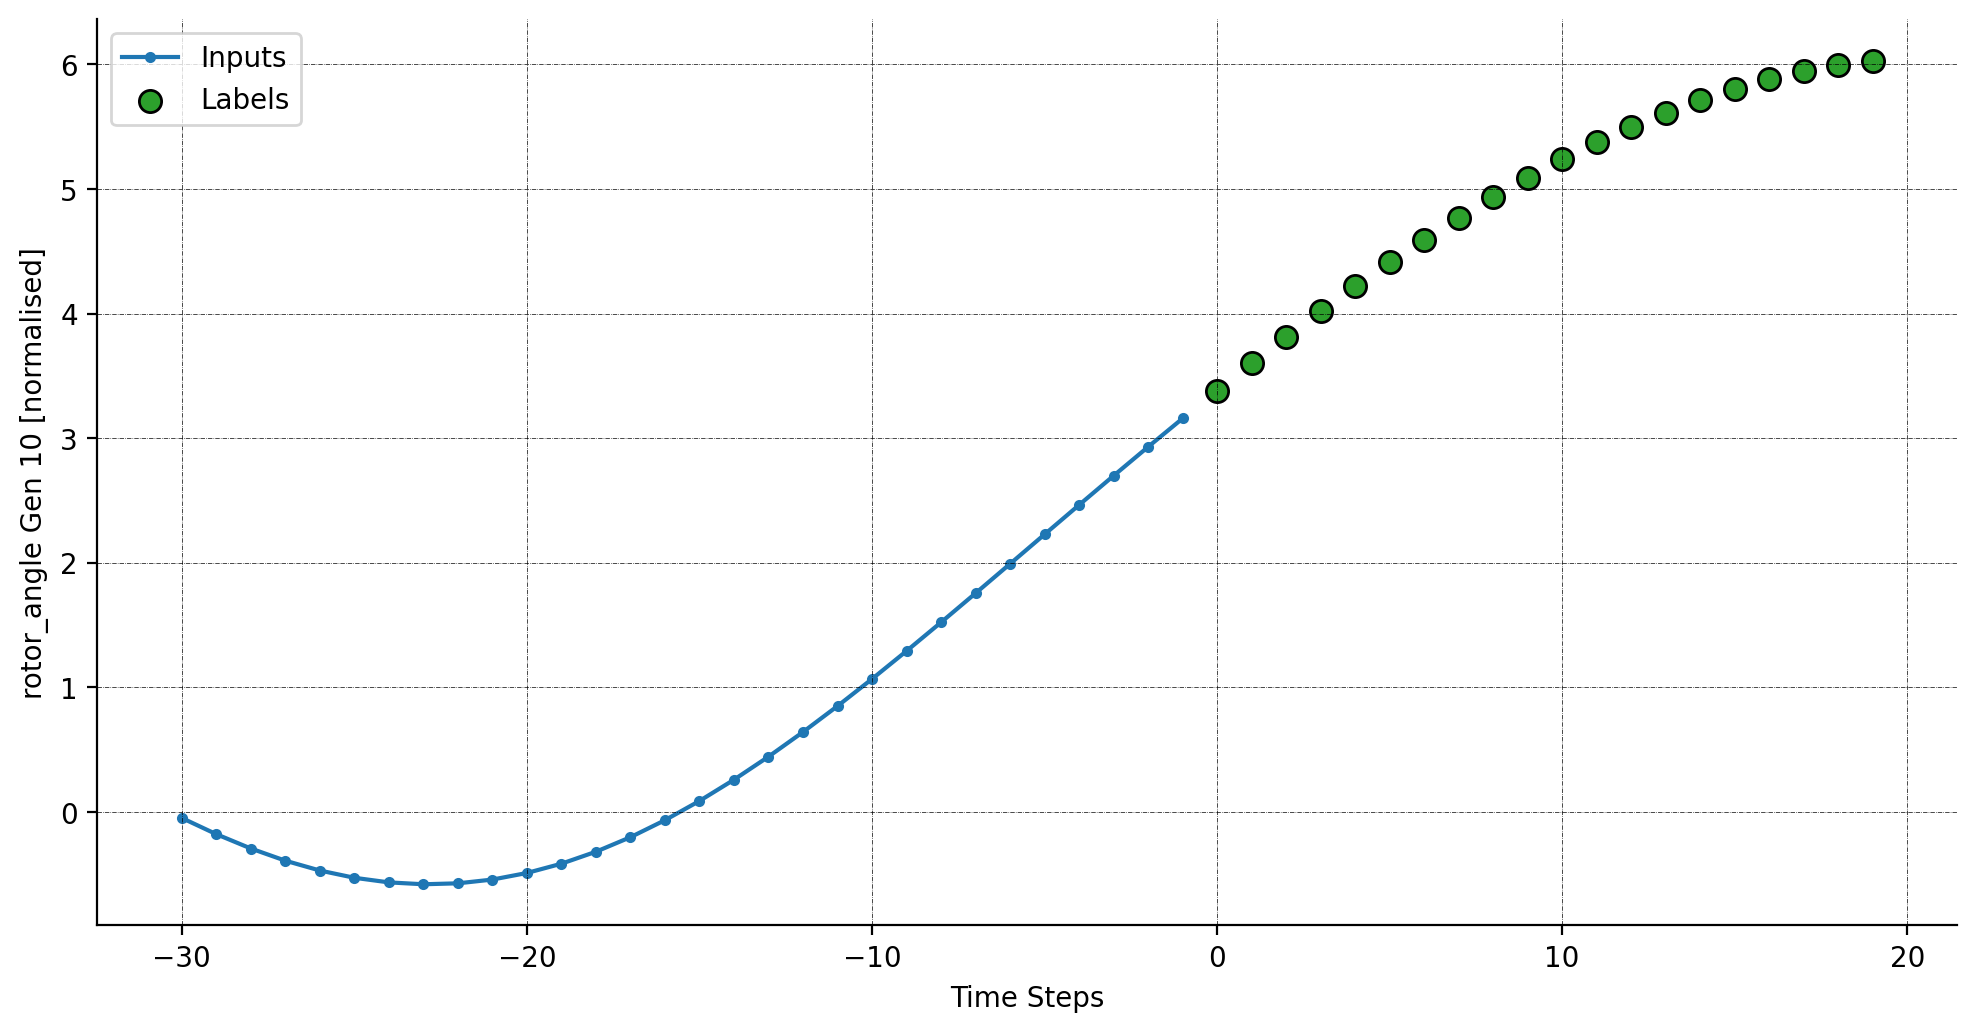

In [ ]:
for x, y in train.take(1):
  multi_step_plot(x[0], y[0], np.array([0]), FEATURE_COLUMN_INDICES,
                  plot_col = "rotor_angle Gen 10")

## Establishing baseline as last step extrapolation 

In [ ]:
MAX_EPOCHS = 20
num_features = x_train.shape[2]
training_samples = X_train.shape[0]
validation_samples = X_val.shape[0]
test_samples = X_test.shape[0]
STEPS_PER_EPOCH = training_samples//BATCH_SIZE
VALIDATION_STEPS = validation_samples//BATCH_SIZE
TEST_STEPS = test_samples//BATCH_SIZE

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, look_forward, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
last_baseline.evaluate(test, steps=TEST_STEPS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3375/3375 [==============================] - 3s 903us/step - loss: 0.4133 - mean_absolute_error: 0.2734


[0.41328030824661255, 0.27337267994880676]

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
multi_val_performance['Last'] = last_baseline.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Last'] = last_baseline.evaluate(test, steps=TEST_STEPS)

3375/3375 [==============================] - 3s 758us/step - loss: 0.4133 - mean_absolute_error: 0.2734


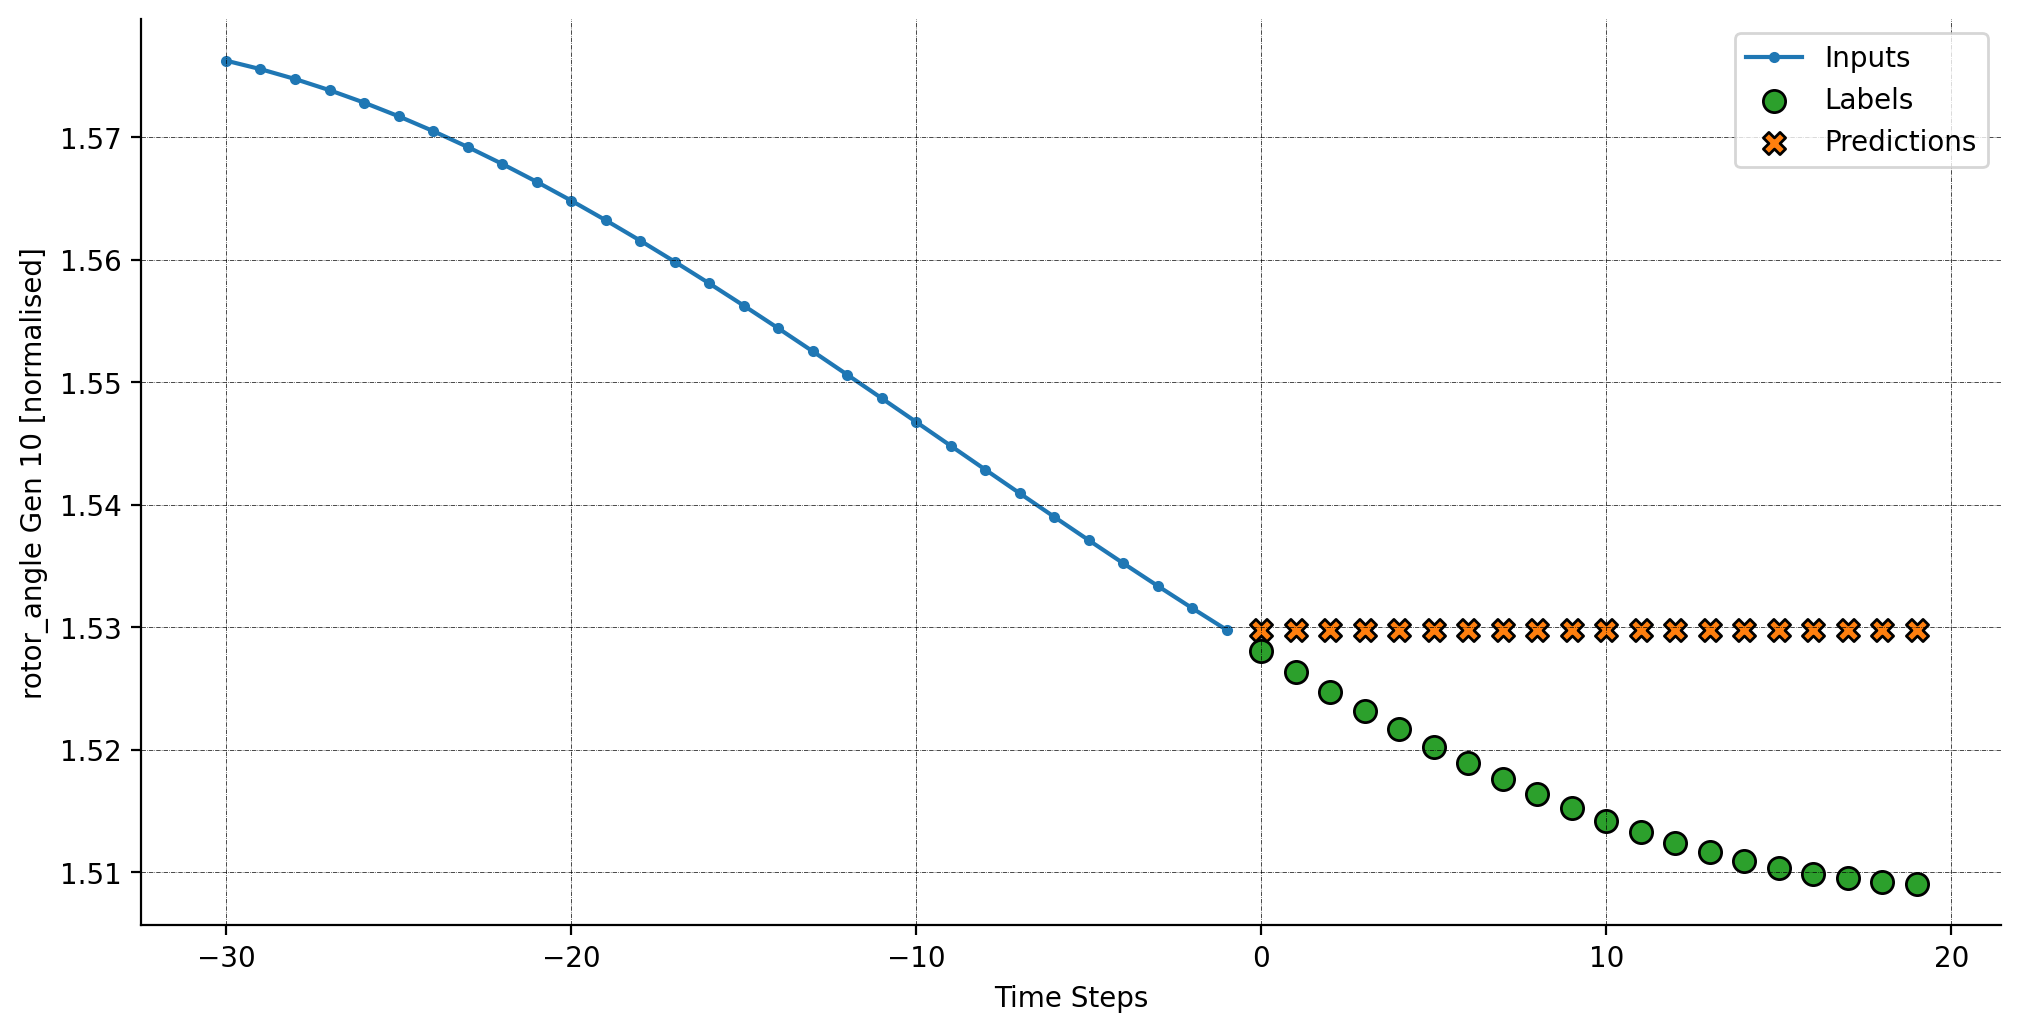

In [ ]:
for x, y in train.take(1):
  multi_step_plot(x[0], y[0], last_baseline.predict(x)[0], FEATURE_COLUMN_INDICES,
                  plot_col = "rotor_angle Gen 10")

## ML Models

## Linear model

3375/3375 [==============================] - 4s 1ms/step - loss: 0.2344 - mean_absolute_error: 0.2344


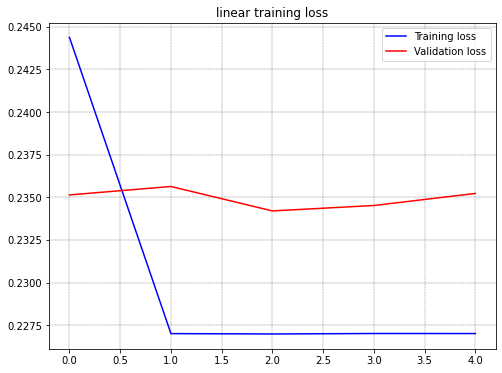

In [ ]:
#linear model
linear_model = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.zeros()),
  # Shape => [batch, look_forward, num_features]
  tf.keras.layers.Reshape([look_forward, num_features])
])

history_linear = compile_and_fit(linear_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
#linear_model.save(bin_path + '/linear_model')

IPython.display.clear_output()
multi_val_performance['Linear'] = linear_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Linear'] = linear_model.evaluate(test, steps=TEST_STEPS)

plot_train_history(history_linear, 'linear training loss')

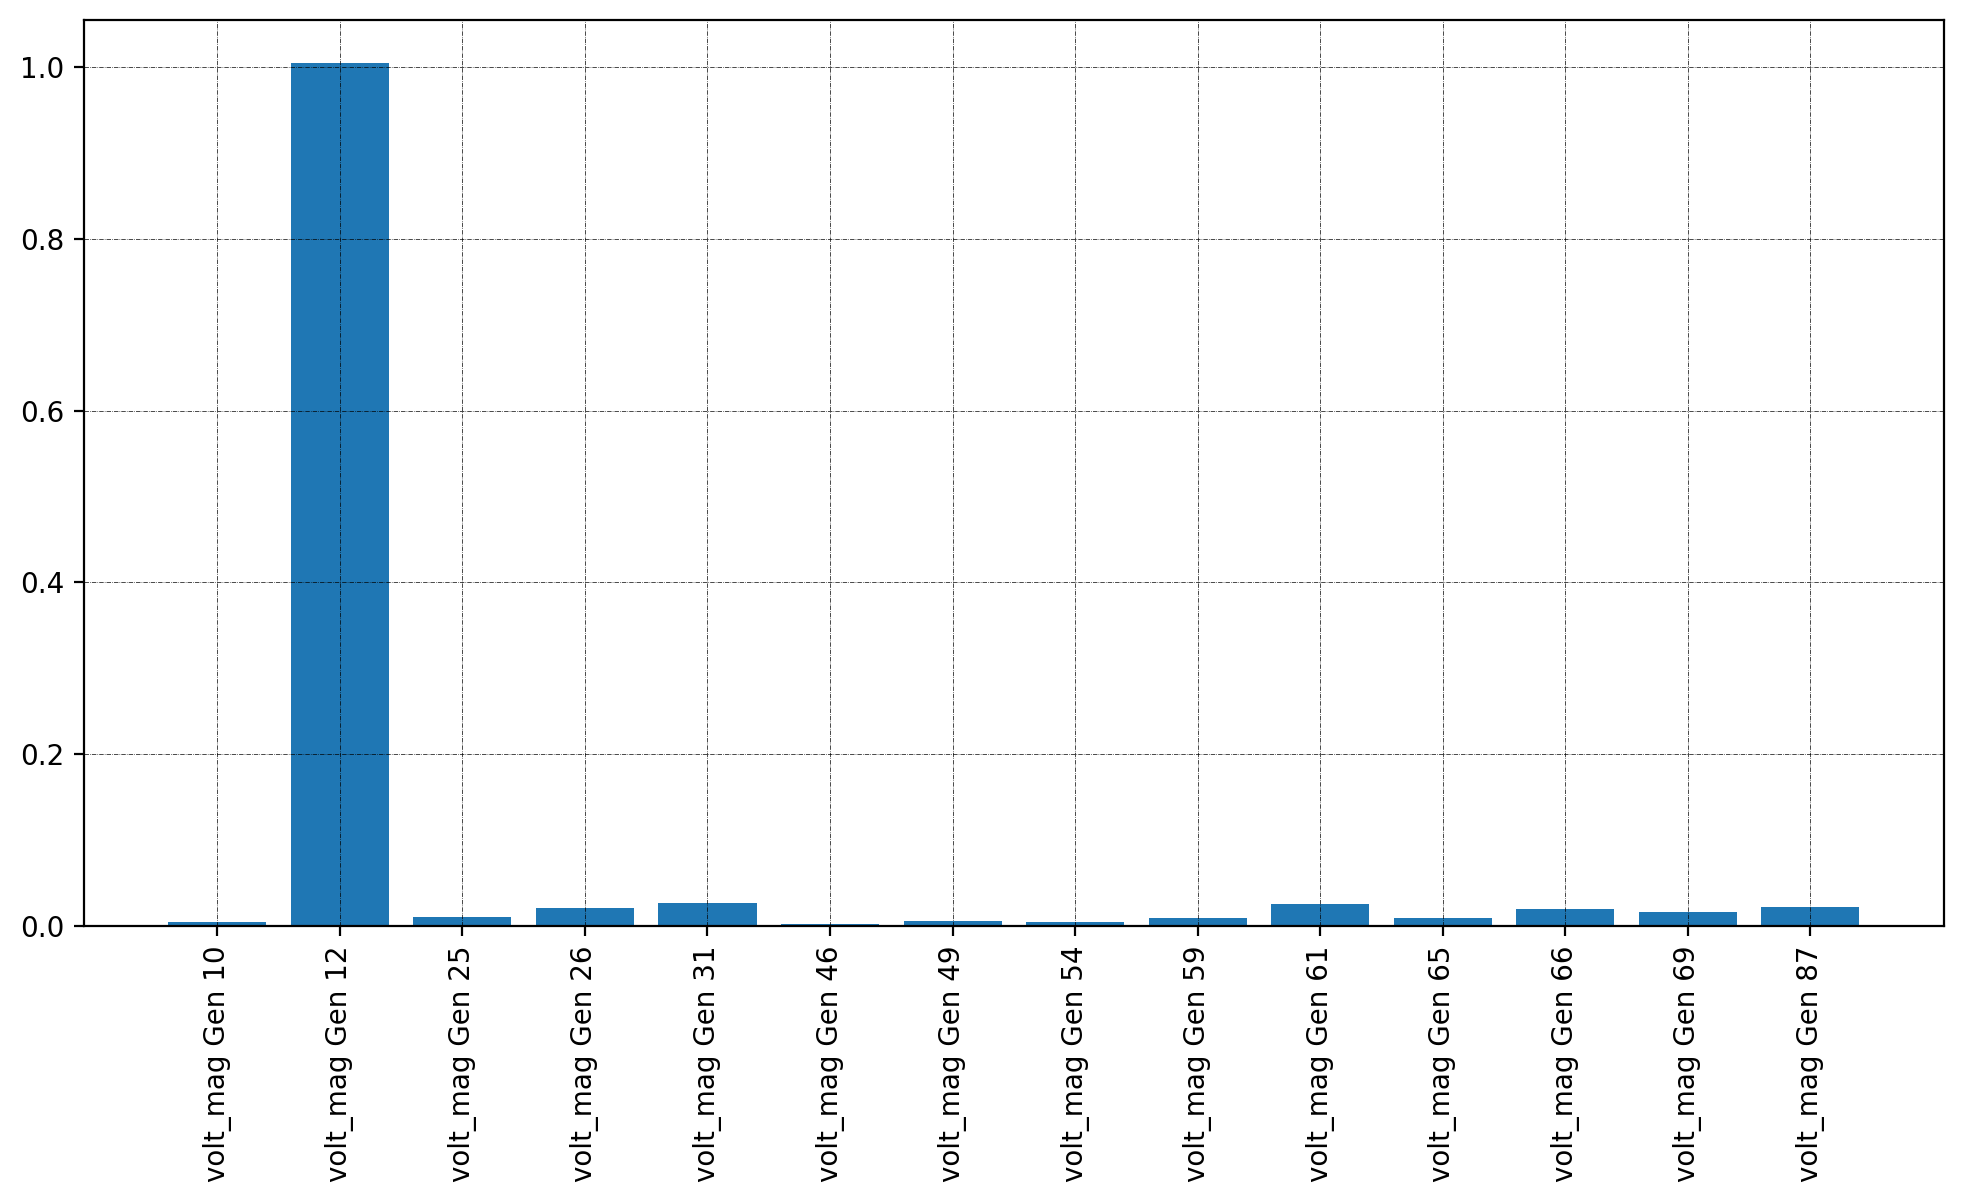

In [ ]:
#plotting linear model weights
#weights found by optimising for MEAN SQUARED ERROR not MAE
plt.figure(figsize=(12, 6), dpi=200)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.bar(x = range(len(feature_columns_indices)),
        height=np.abs(linear_model.layers[1].kernel[:,1].numpy()))
axis = plt.gca()
axis.set_xticks(range(len(feature_columns_indices)))
_ = axis.set_xticklabels(columns, rotation=90)

## Linear model with added dense layer

3375/3375 [==============================] - 8s 2ms/step - loss: 0.1805 - mean_absolute_error: 0.1805


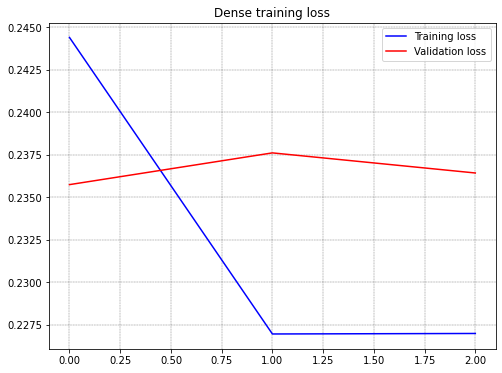

In [ ]:
#adding single dense layer to simple linear model
dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(look_forward*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([look_forward, num_features])
])

dense_history = compile_and_fit(dense_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
dense_model.save(bin_path + '/single_dense')

IPython.display.clear_output()
multi_val_performance['Dense'] = dense_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Dense'] = dense_model.evaluate(test, steps=TEST_STEPS)

plot_train_history(history_linear, 'Dense training loss')

## Dense layer and single convolution

3375/3375 [==============================] - 8s 2ms/step - loss: 0.0946 - mean_absolute_error: 0.0946


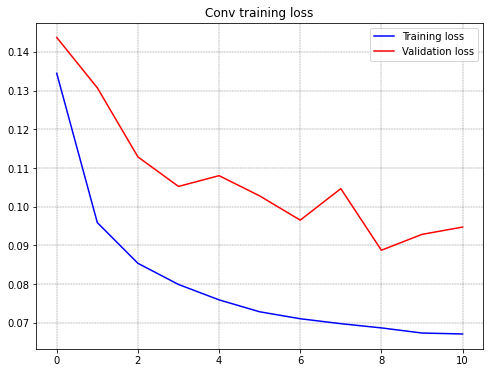

In [ ]:
CONV_WIDTH = 5
conv_model = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
  tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([look_forward, num_features])
])

conv_history = compile_and_fit(conv_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
conv_model.save(bin_path + '/conv_model')

IPython.display.clear_output()

multi_val_performance['Conv'] = conv_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Conv'] = conv_model.evaluate(test, steps=TEST_STEPS)
plot_train_history(conv_history, 'Conv training loss')

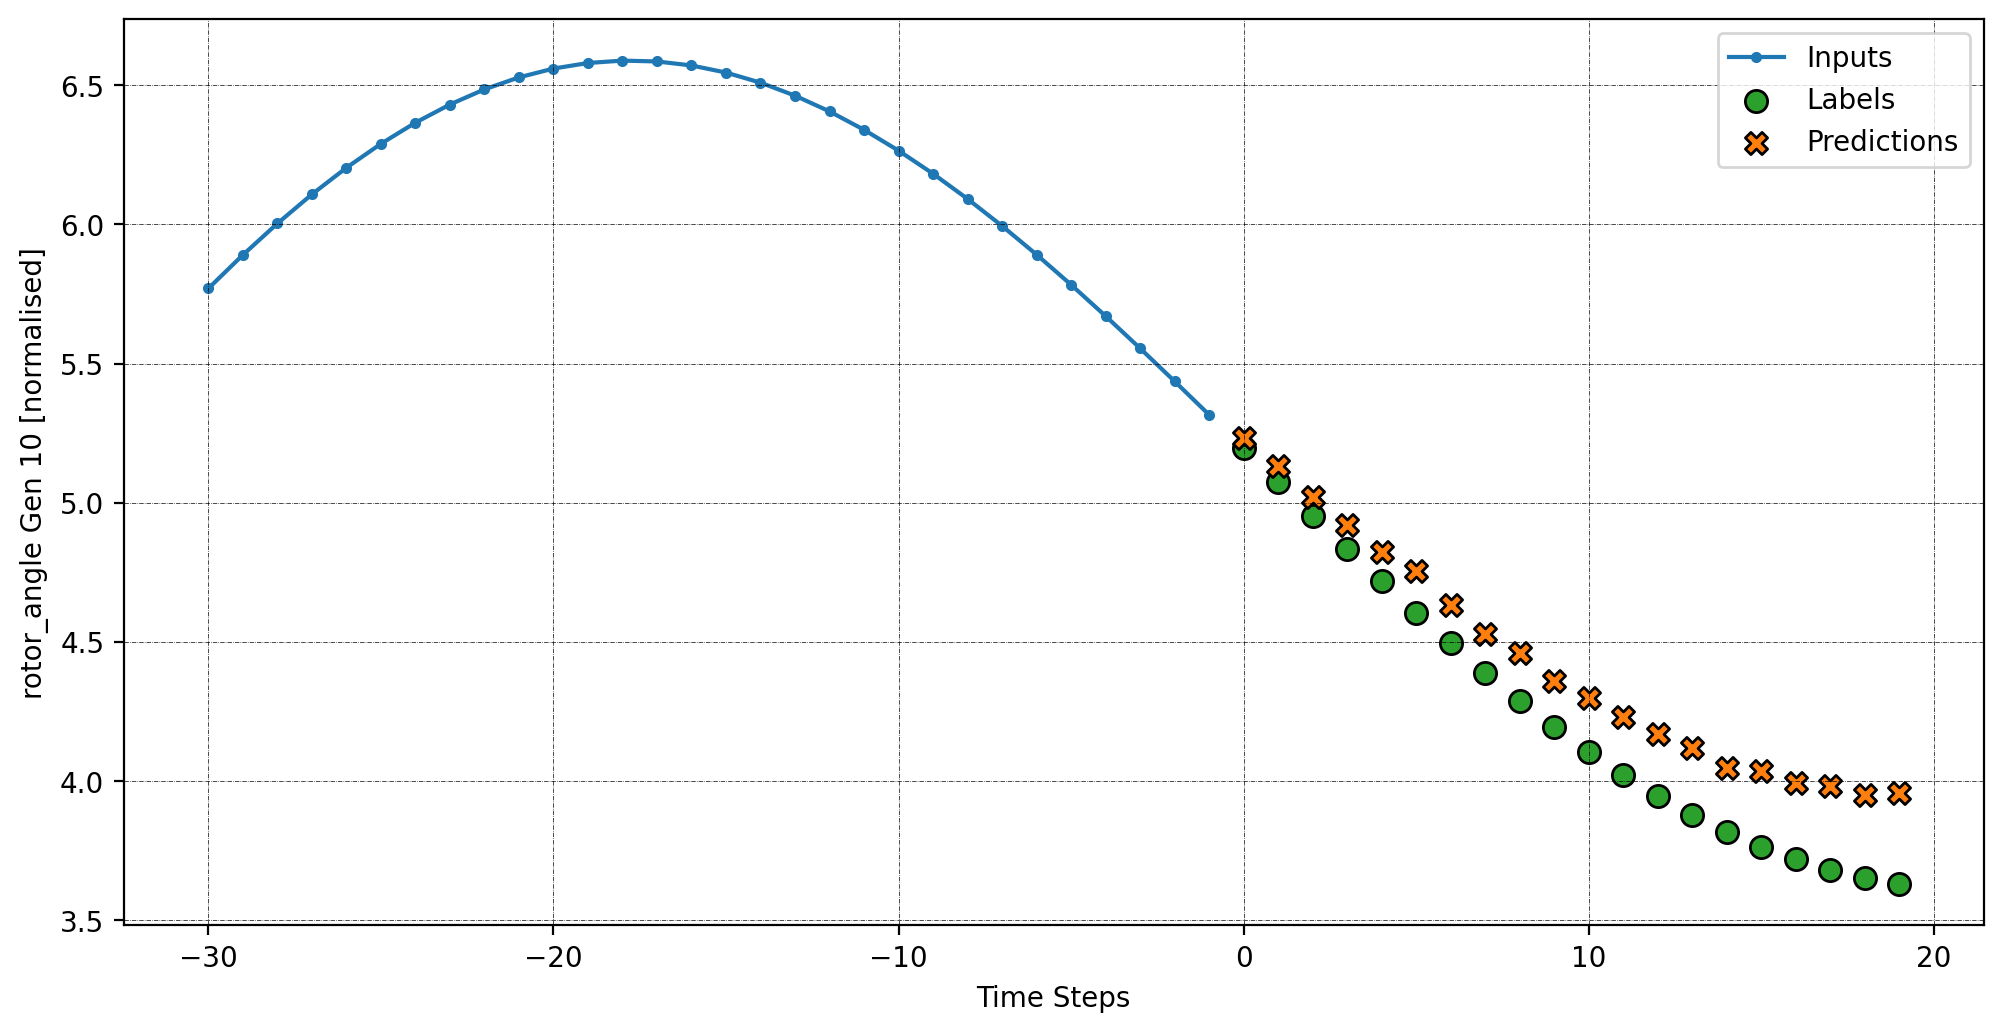

In [ ]:
for x, y in train.take(1):
  multi_step_plot(x[0], y[0], conv_model.predict(x)[0], 
                  plot_col = "rotor_angle Gen 10")

## LSTM Model

## Finding a good learning late with learning rate scheduler 

In [ ]:
lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=False),
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_features])
])

history_lstm = learning_rate_scheduler(lstm_model, train, STEPS_PER_EPOCH)
IPython.display.clear_output()

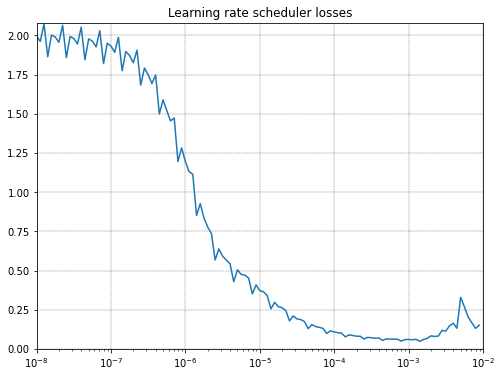

In [ ]:
plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
plt.axis([1e-8 * 10**(0 / 20), 1e-8 * 10**(120 / 20), 0, 2.08])
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.title("Learning rate scheduler losses")
plt.show()

3375/3375 [==============================] - 9s 3ms/step - loss: 0.0437 - mean_absolute_error: 0.0437


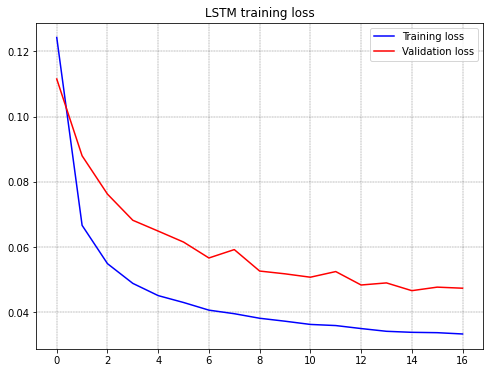

In [ ]:
lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=False),
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_features])
])

history_lstm = compile_and_fit(lstm_model, conv_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS, learning_rate=1e-3)
lstm_model.save(bin_path + '/single_lstm_model')

IPython.display.clear_output()

multi_val_performance['LSTM'] = lstm_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['LSTM'] = lstm_model.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_lstm, 'LSTM training loss')

In [ ]:
lstm_plot = tf.keras.models.load_model(bin_path+'/single_lstm_model')

## Bidirectional LSTM

3375/3375 [==============================] - 14s 4ms/step - loss: 0.0530 - mean_absolute_error: 0.0530


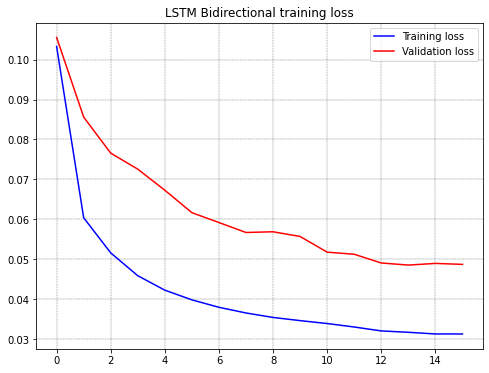

In [ ]:
lstm_model_bidirectional = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_features])
])

history_lstm_bidirectional = compile_and_fit(lstm_model_bidirectional, conv_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS, learning_rate=1e-3)
lstm_model_bidirectional.save(bin_path + '/single_lstm_bidirectional_model')

IPython.display.clear_output()

multi_val_performance['Bi-LSTM'] = lstm_model_bidirectional.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Bi-LSTM'] = lstm_model_bidirectional.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_lstm_bidirectional, 'LSTM Bidirectional training loss')

In [ ]:
# Save
np.save(bin_path + '/val_results.npy', multi_val_performance) 
np.save(bin_path + '/test_results.npy', multi_performance) 

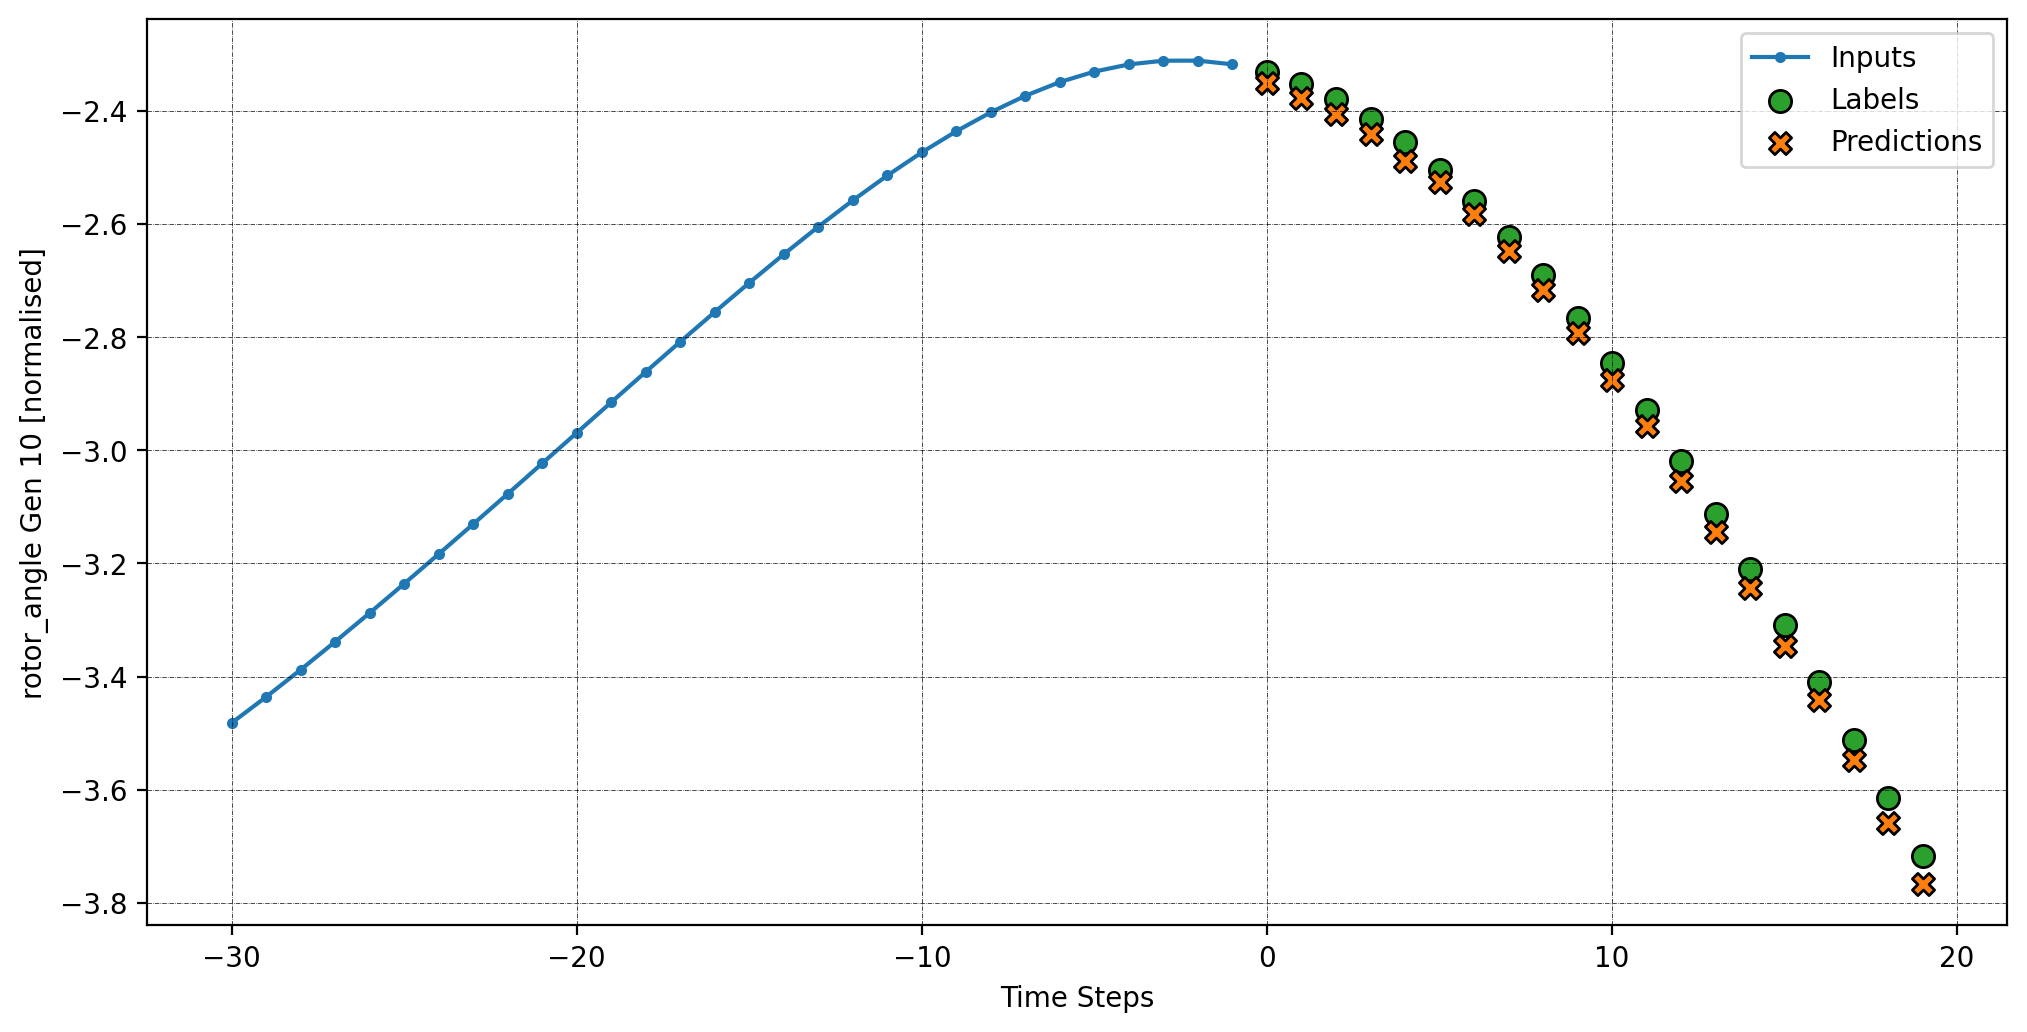

In [ ]:
for x, y in test.take(1):
  multi_step_plot(x[0], y[0], lstm_model_bidirectional.predict(x)[0], 
                  plot_col = "rotor_angle Gen 10")

## Autoencoder


In [ ]:
#simple autoencoder bidirectiional

lstm_encoder_bi = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=[None, len(FEATURE_COLUMNS)]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30))
])

lstm_decoder_bi = tf.keras.Sequential([
  tf.keras.layers.RepeatVector(look_back, input_shape=[60]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(FEATURE_COLUMNS)))
])

lstm_autoencoder_bi = tf.keras.Sequential([lstm_encoder_bi, lstm_decoder_bi])

history_autoencoder = compile_and_fit(lstm_autoencoder_bi, conv_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS, learning_rate=1e-3)
lstm_autoencoder_bi.save(bin_path + '/autoencoder')

IPython.display.clear_output()

lstm_autoencoder_bi.evaluate(val_auto_encoder, steps=VALIDATION_STEPS)
plot_train_history(history_autoencoder, 'Autoencoder training loss')

6750/6750 [==============================] - 52s 8ms/step - loss: 0.0252 - mean_absolute_error: 0.0252


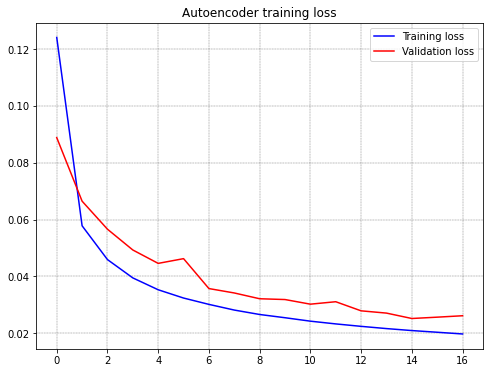

In [ ]:
lstm_autoencoder_bi.evaluate(val_auto_encoder, steps=VALIDATION_STEPS)
plot_train_history(history_autoencoder, 'Autoencoder training loss')

## loading encoder

In [ ]:
# Load results
multi_val_performance = np.load(bin_path+'/val_results.npy',allow_pickle='TRUE').item()
multi_performance = np.load(bin_path+'/test_results.npy',allow_pickle='TRUE').item()

In [ ]:
autoencoder = tf.keras.models.load_model(bin_path+'/autoencoder')

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 60)                147440    
_________________________________________________________________
sequential_1 (Sequential)    (None, 30, 14)            131614    
Total params: 279,054
Trainable params: 279,054
Non-trainable params: 0
_________________________________________________________________


3375/3375 [==============================] - 20s 6ms/step - loss: 0.0520 - mean_absolute_error: 0.0520


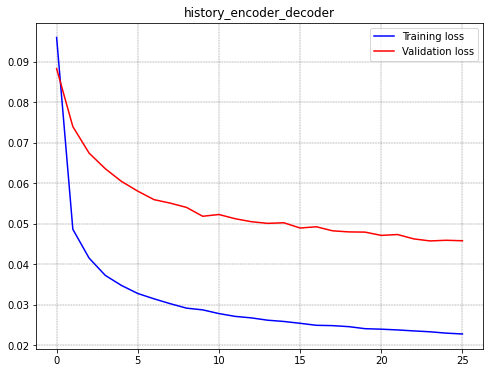

In [ ]:
encoder = autoencoder.layers[0]
encoder.trainable = False

decoder = tf.keras.Sequential([
  tf.keras.layers.RepeatVector(look_back, input_shape=[60]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)), 
  tf.keras.layers.Dense(look_forward*num_features,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_features])
], name = 'decoder')

encoder_decoder = tf.keras.Sequential([encoder, decoder])

history_encoder_decoder = compile_and_fit(encoder_decoder, conv_model, train, val, 
                                          STEPS_PER_EPOCH, VALIDATION_STEPS, 
                                          MAX_EPOCHS, learning_rate=1e-3)
encoder_decoder.save(bin_path + '/encoder_decoder')

IPython.display.clear_output()

multi_val_performance['encoder_decoder'] = encoder_decoder.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['encoder_decoder'] = encoder_decoder.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_encoder_decoder, 'history_encoder_decoder')

In [ ]:
## retraining autoencoder
encoder_decoder = tf.keras.models.load_model(bin_path+'/encoder_decoder')
encoder_decoder.layers[0].trainable = False

history_encoder_decoder = compile_and_fit(encoder_decoder, conv_model, train, val, 
                                          STEPS_PER_EPOCH, VALIDATION_STEPS, 
                                          MAX_EPOCHS, learning_rate=1e-4)
encoder_decoder.save(bin_path + '/encoder_decoder')

IPython.display.clear_output()

encoder_decoder.evaluate(val, steps=VALIDATION_STEPS)
encoder_decoder.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_encoder_decoder, 'history_encoder_decoder')

## Comparing linear model and encoder/decoder

In [ ]:
linear_plot = tf.keras.models.load_model(bin_path+'/linear_model') 
e_d_plot = tf.keras.models.load_model(bin_path+'/encoder_decoder')

linear


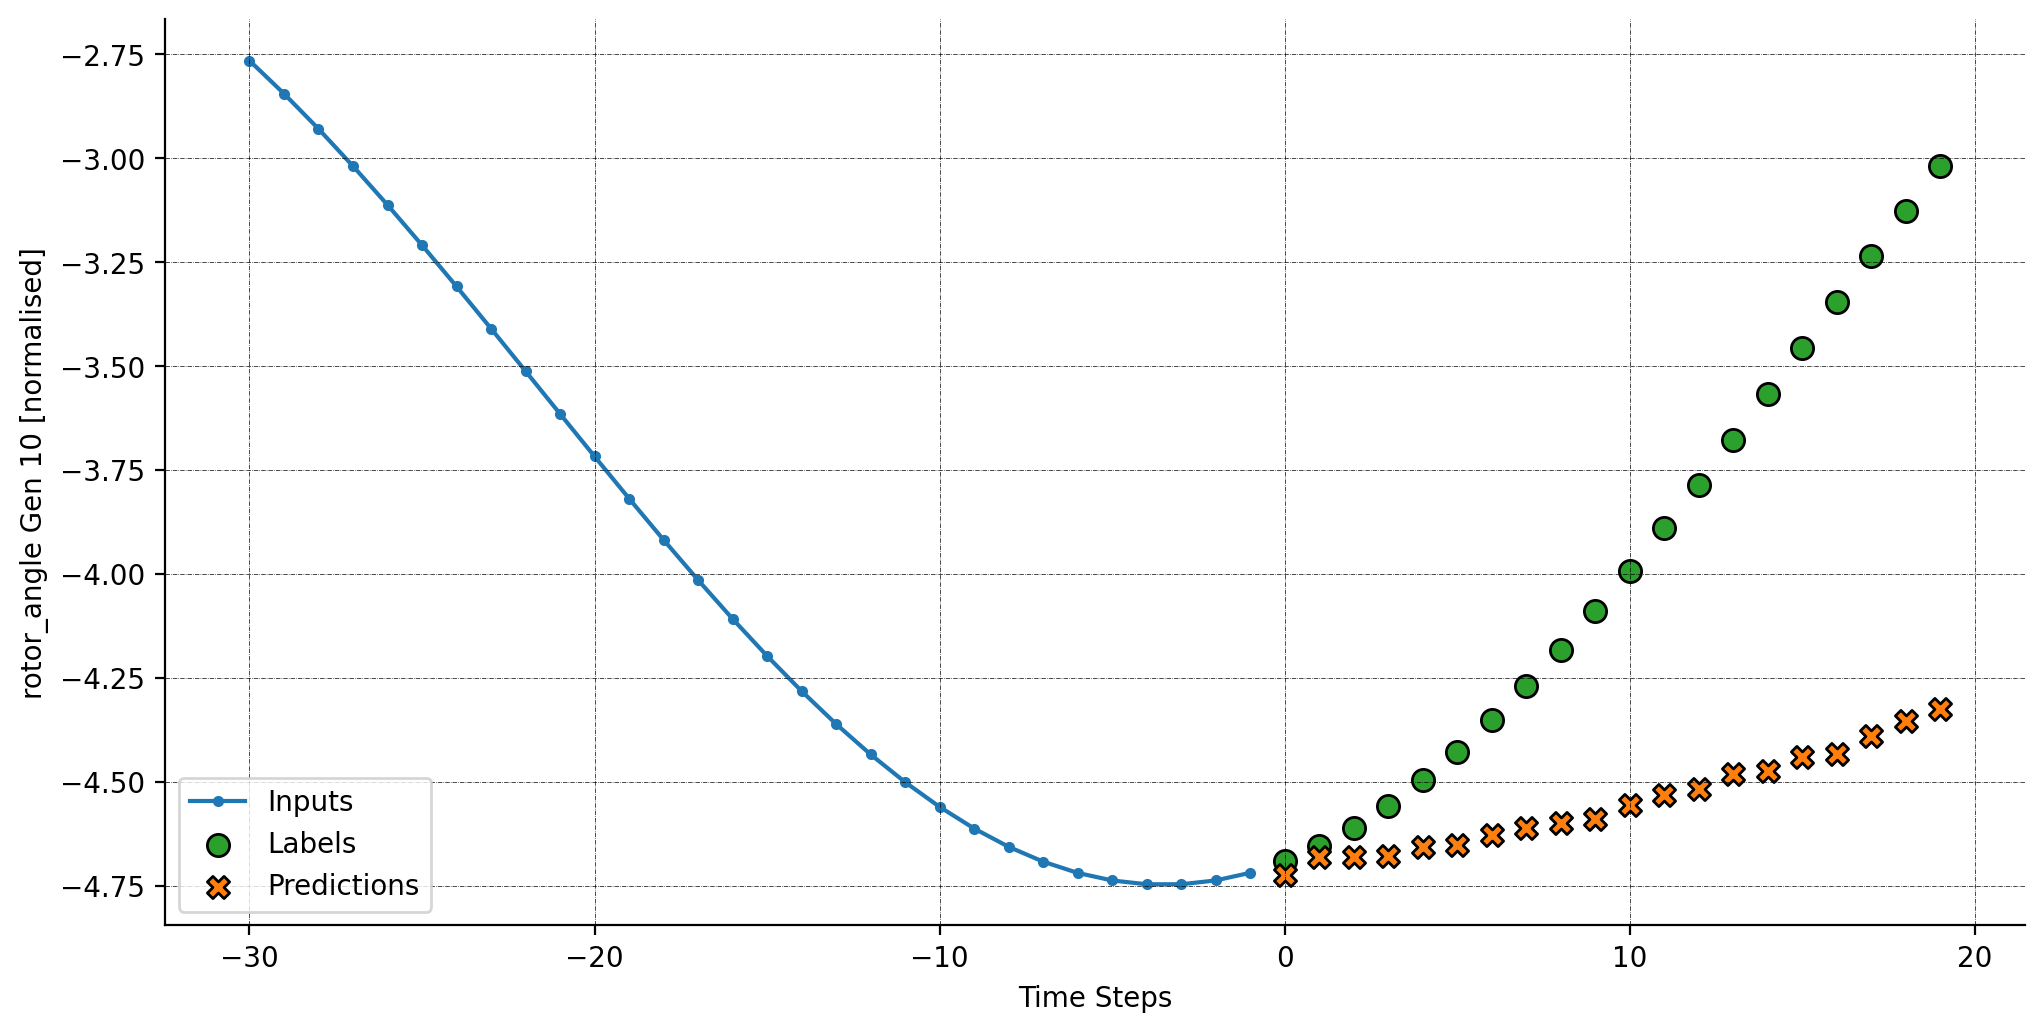

Encoder-decoder


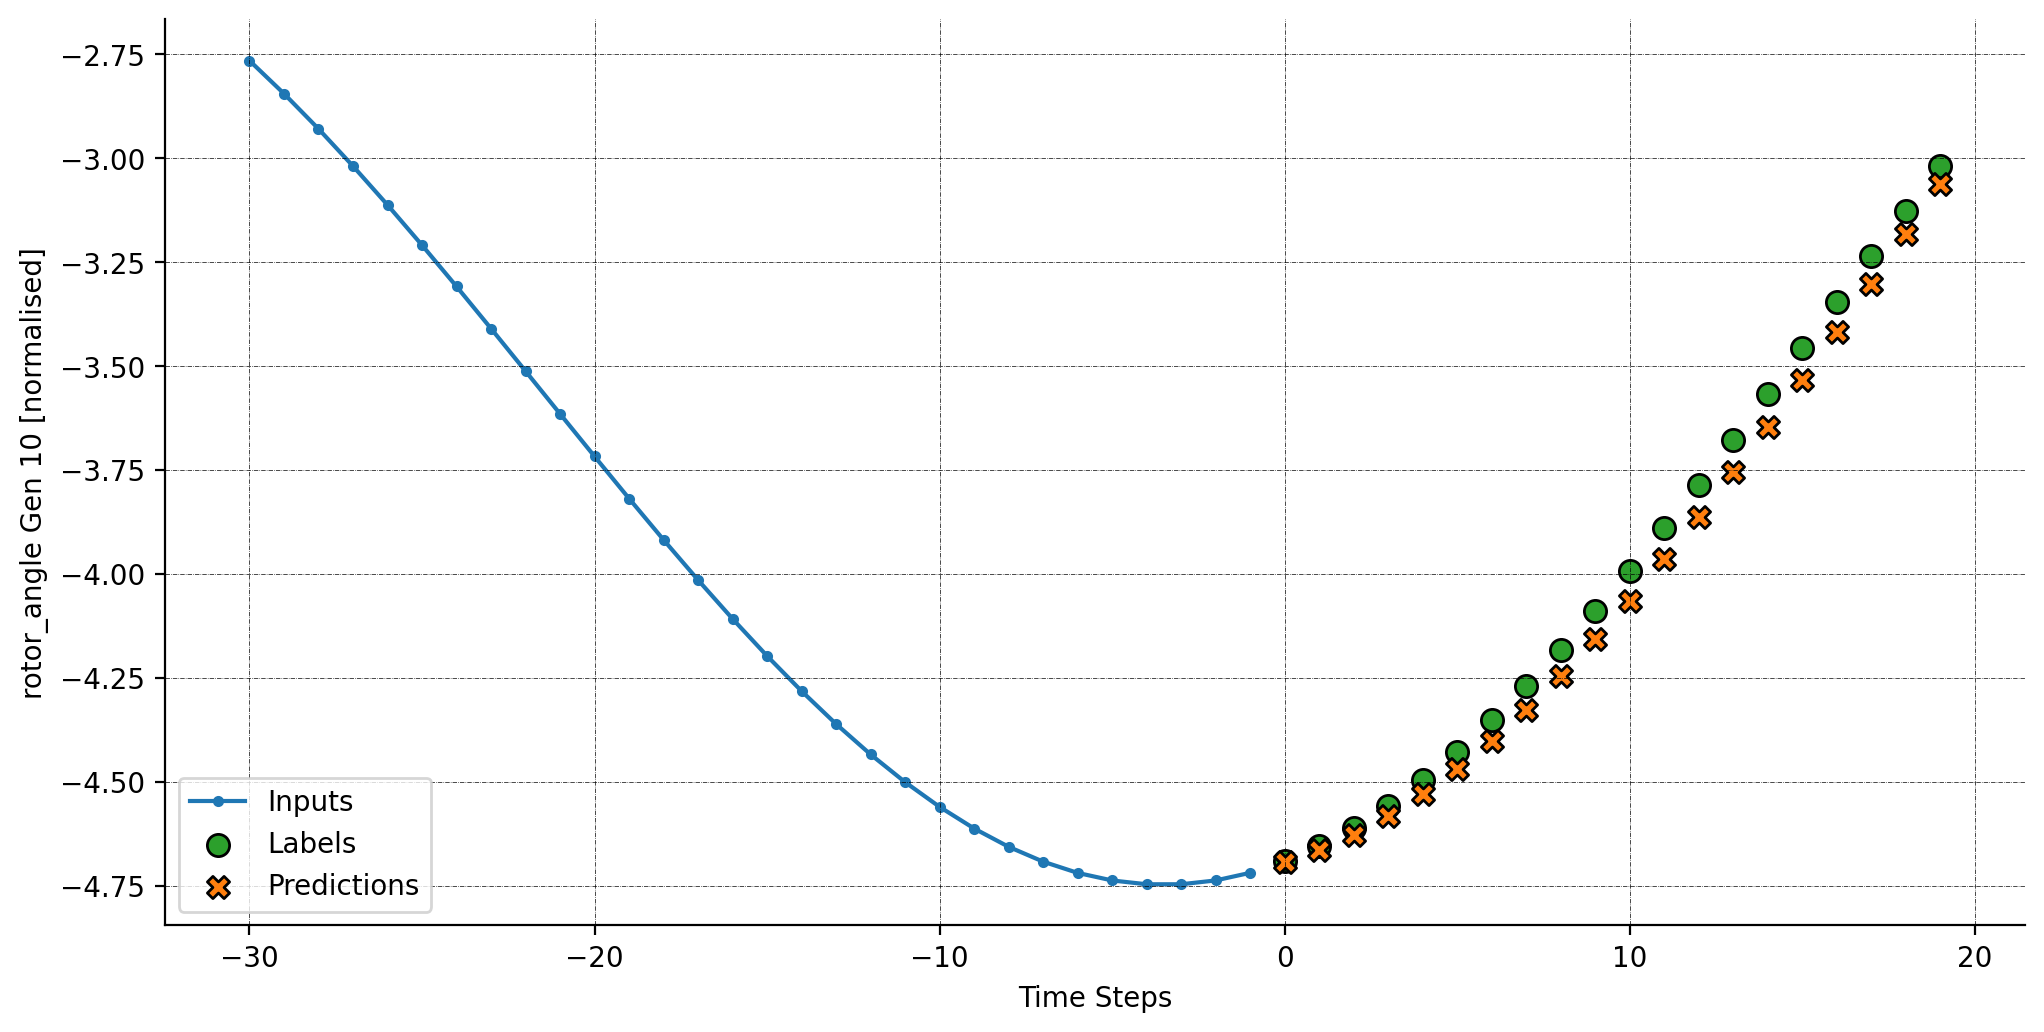

In [ ]:
for x, y in train.take(1):
  print('linear')
  multi_step_plot(x[0], y[0], linear_plot.predict(x)[0], FEATURE_COLUMN_INDICES,
                  plot_col = "rotor_angle Gen 10")
  print('Encoder-decoder')
  multi_step_plot(x[0], y[0], e_d_plot.predict(x)[0], FEATURE_COLUMN_INDICES,
                  plot_col = "rotor_angle Gen 10")